In [237]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [341]:
data = pd.read_csv('processed_datasets/GMSL_analysis_and_prediction.csv', delimiter=',')

In [342]:
data.head().append(data.tail())

,Date,Extent,WaterTemp,O2ml,SiO3,NO3,LandAverageTemperature,LandAndOceanAverageTemperature,CO2,IsGMSLIncreased,GMSL
0,1969-01,11.412998,13.265000,5.595000,7.00000,3.250,1.966,13.518,324.00,0,-35.8
1,1969-02,11.419180,12.435000,5.695000,6.40000,5.200,2.450,13.747,324.42,0,-37.2
2,1969-03,11.425310,15.535000,5.490000,4.00000,0.300,5.131,14.576,325.64,1,-36.2
3,1969-04,11.431388,12.070000,5.312500,8.50000,6.400,8.576,15.518,326.66,0,-37.4
4,1969-05,11.437415,12.120000,5.945000,6.00000,3.700,11.354,16.329,327.34,0,-38.6
535,2013-08,12.338645,12.053062,5.263625,7.47125,8.925,14.742,17.462,395.20,1,71.6
536,2013-09,12.298467,12.200875,5.302750,6.75750,8.100,13.154,16.894,393.45,0,68.8
537,2013-10,13.236306,12.348688,5.341875,6.04375,7.275,10.256,15.905,393.70,0,66.4
538,2013-11,13.405600,12.496500,5.381000,5.33000,6.450,7.424,15.107,395.16,0,59.7
539,2013-12,13.066000,13.062250,5.427250,4.62625,4.275,4.724,14.339,396.84,0,58.5


In [343]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data.sort_index()
data

,Extent,WaterTemp,O2ml,SiO3,NO3,LandAverageTemperature,LandAndOceanAverageTemperature,CO2,IsGMSLIncreased,GMSL
Date,,,,,,,,,,
1969-01-01,11.412998,13.265000,5.595000,7.00000,3.250,1.966,13.518,324.00,0,-35.8
1969-02-01,11.419180,12.435000,5.695000,6.40000,5.200,2.450,13.747,324.42,0,-37.2
1969-03-01,11.425310,15.535000,5.490000,4.00000,0.300,5.131,14.576,325.64,1,-36.2
1969-04-01,11.431388,12.070000,5.312500,8.50000,6.400,8.576,15.518,326.66,0,-37.4
1969-05-01,11.437415,12.120000,5.945000,6.00000,3.700,11.354,16.329,327.34,0,-38.6
...,...,...,...,...,...,...,...,...,...,...
2013-08-01,12.338645,12.053062,5.263625,7.47125,8.925,14.742,17.462,395.20,1,71.6
2013-09-01,12.298467,12.200875,5.302750,6.75750,8.100,13.154,16.894,393.45,0,68.8
2013-10-01,13.236306,12.348688,5.341875,6.04375,7.275,10.256,15.905,393.70,0,66.4


In [344]:
# Split train-val-test
# ==============================================================================
end_train = '2008-12-01'
end_validation = '2011-12-01'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 1969-01-01 00:00:00 --- 2008-12-01 00:00:00  (n=480)
Dates validacion : 2008-12-01 00:00:00 --- 2011-12-01 00:00:00  (n=37)
Dates test       : 2011-12-01 00:00:00 --- 2013-12-01 00:00:00  (n=25)


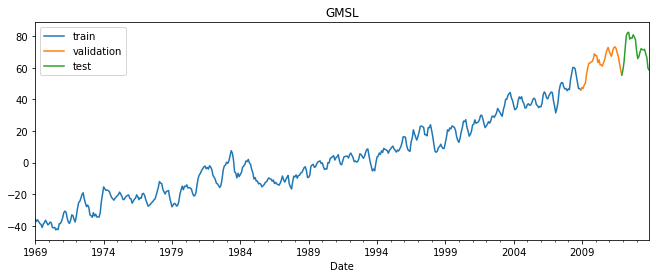

In [345]:
fig, ax = plt.subplots(figsize=(11, 4))
data_train['GMSL'].plot(ax=ax, label='train')
data_val['GMSL'].plot(ax=ax, label='validation')
data_test['GMSL'].plot(ax=ax, label='test')
ax.set_title('GMSL')
ax.legend()

In [346]:
exog_variables = [column for column in data.columns
                      if column.startswith(('Extent', 'WaterTemp', 'O2ml', 'SiO3', 'NO3', 'LandAverageTemperature', 'LandAndOceanAverageTemperature', 'CO2'))]
print(exog_variables)

['Extent', 'WaterTemp', 'O2ml', 'SiO3', 'NO3', 'LandAverageTemperature', 'LandAndOceanAverageTemperature', 'CO2']


In [347]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 8
             )

In [340]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [3, 5, 6, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
#lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'GMSL'],
                        exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 1,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        return_best        = True,
                        verbose            = False
                   )

TypeError: can only concatenate str (not "int") to str

In [360]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['GMSL'],
    exog               = data[exog_variables],
    initial_train_size = len(data.loc[:end_validation])-1,
    steps              = 1,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

Backtest error: [71.2320339]


In [361]:
importance = forecaster.get_feature_importance()
#importance

In [362]:
# Predictions
# ==============================================================================
#predictions

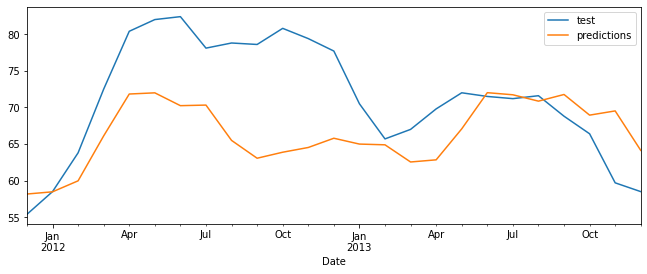

In [363]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['GMSL'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [332]:
predictions['pred']

2012-01-01    55.990406
2012-02-01    57.699509
2012-03-01    64.786713
2012-04-01    72.304031
2012-05-01    72.191246
2012-06-01    70.778252
2012-07-01    71.097580
2012-08-01    67.143089
2012-09-01    67.305679
2012-10-01    66.380280
2012-11-01    67.282158
2012-12-01    69.047150
2013-01-01    67.924004
2013-02-01    67.883080
2013-03-01    64.085823
2013-04-01    64.668198
2013-05-01    68.404221
2013-06-01    72.651794
2013-07-01    72.583084
2013-08-01    71.273651
2013-09-01    71.329727
2013-10-01    68.671829
2013-11-01    67.804749
2013-12-01    61.833637
Freq: MS, Name: pred, dtype: float64

In [331]:
data_test['GMSL']

Date
2011-12-01    55.4
2012-01-01    58.5
2012-02-01    63.8
2012-03-01    72.5
2012-04-01    80.4
2012-05-01    82.0
2012-06-01    82.4
2012-07-01    78.1
2012-08-01    78.8
2012-09-01    78.6
2012-10-01    80.8
2012-11-01    79.4
2012-12-01    77.7
2013-01-01    70.5
2013-02-01    65.7
2013-03-01    67.0
2013-04-01    69.8
2013-05-01    72.0
2013-06-01    71.5
2013-07-01    71.2
2013-08-01    71.6
2013-09-01    68.8
2013-10-01    66.4
2013-11-01    59.7
2013-12-01    58.5
Freq: MS, Name: GMSL, dtype: float64